# Italian Financial Challenge - Starter Template

**Student Name:** [Your Name]

**Challenge:** [Choose: Bankruptcy Prediction / Financial Health Classification / Revenue Forecasting]

**Date:** [Date]

---

## Instructions

This template provides a suggested structure for your challenge solution. You can adapt it to your needs, but make sure to cover all required sections:

1. Problem Statement and Objectives
2. Data Loading and Exploration
3. Data Preprocessing
4. Feature Engineering
5. Model Development
6. Model Evaluation
7. Interpretation and Business Insights
8. Conclusions and Future Work

**Remember:**
- Document your thought process with markdown cells
- Comment your code clearly
- Create visualizations to support your insights
- Interpret results in business terms
- Check the evaluation rubric to ensure you meet all criteria

## 1. Problem Statement and Objectives

**Challenge:** [Describe which challenge you chose and why]

**Objective:** [State the prediction goal clearly]

**Success Criteria:** [Define what "good" performance looks like for your chosen challenge]

**Approach:** [Briefly outline your planned approach]

In [28]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

# Create images folder for saved plots
IMAGES_DIR = Path('../images')
IMAGES_DIR.mkdir(exist_ok=True)

def save_fig(name, dpi=150):
    path = IMAGES_DIR / f"{name}.png"
    plt.savefig(path, dpi=dpi, bbox_inches="tight")



Libraries imported successfully!


## 2. Data Loading and Exploration (Refactored EDA: Lean, Defensible, Leakage-Safe)

This section prioritizes a minimal, high-signal set of plots (8–10) with scale-aware visuals.


### 1. Dataset Overview


In [29]:
# Load training data
train_df = pd.read_csv('../data/processed/train_data.csv')

# Keep full dataset for modeling (EDA uses train-only split)
full_df = train_df.copy()

# Recompute revenue_change from production_value (t vs t-1)
if {'company_id', 'fiscal_year', 'production_value'} <= set(full_df.columns):
    full_df = full_df.sort_values(['company_id', 'fiscal_year']).copy()
    pv_prev = full_df.groupby('company_id')['production_value'].shift(1)
    full_df['revenue_change'] = (full_df['production_value'] - pv_prev) / pv_prev
    print('Recomputed revenue_change from production_value (t vs t-1)')

# EDA split (train-only to avoid leakage)
train_years_eda = [2018, 2019, 2020]
val_year_eda = 2021
if 'fiscal_year' in full_df.columns:
    train_df = full_df[full_df['fiscal_year'].isin(train_years_eda)].copy()
else:
    train_df = full_df.copy()

# Explicit target definition for Challenge 3
target_col = 'revenue_change'
target_definition = "Percent change in production_value vs prior year"
target_units = "percentage (%)"

# Columns that are coded as numeric but represent categories
categorical_like_cols = ['ateco_sector'] if 'ateco_sector' in train_df.columns else []

# Basic dataset info
print(f"Full dataset shape (rows, cols): {full_df.shape}")
print(f"EDA dataset (train-only) rows: {train_df.shape[0]}")
print(f"Unique companies (EDA): {train_df['company_id'].nunique()}")
print(f"Fiscal year range (EDA): {train_df['fiscal_year'].min()} - {train_df['fiscal_year'].max()}")
print(f"Target: {target_col} ({target_units}) - {target_definition}")

# Feature type breakdown
id_cols = ['company_id']
time_cols = ['fiscal_year']
leakage_targets = ['bankruptcy_next_year', 'financial_health_class']

numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

numeric_features = [
    c for c in numeric_cols
    if c not in id_cols + time_cols + [target_col] + leakage_targets + categorical_like_cols
]

categorical_features = [c for c in categorical_cols if c not in id_cols + leakage_targets]
for c in categorical_like_cols:
    if c not in categorical_features:
        categorical_features.append(c)

print("\nFeature type counts:")
print(f"Identifiers: {id_cols}")
print(f"Time columns: {time_cols}")
print(f"Target column: {target_col}")
print(f"Other target cols to exclude: {leakage_targets}")
print(f"Numeric feature cols: {len(numeric_features)}")
print(f"Categorical feature cols: {len(categorical_features)}")
print(f"Total usable feature cols: {len(numeric_features) + len(categorical_features)}")


Recomputed revenue_change from production_value (t vs t-1)
Full dataset shape (rows, cols): (11828, 30)
EDA dataset (train-only) rows: 8896
Unique companies (EDA): 2999
Fiscal year range (EDA): 2018 - 2020
Target: revenue_change (percentage (%)) - Percent change in production_value vs prior year

Feature type counts:
Identifiers: ['company_id']
Time columns: ['fiscal_year']
Target column: revenue_change
Other target cols to exclude: ['bankruptcy_next_year', 'financial_health_class']
Numeric feature cols: 21
Categorical feature cols: 4
Total usable feature cols: 25


**What this shows:** dataset scale, feature types, and explicit exclusion of leakage targets.  
**Why it matters for modeling:** establishes which columns are safe and eligible for feature engineering.


**Units and domain assumptions:**
- Monetary columns are annual values in euros.
- Ratio columns are unitless and may be negative when equity/profit is negative.
- `revenue_change` is a percent (%) derived from year-over-year production value.


### 2. Helper Functions (Reusable, Leakage-Safe)


In [30]:
# Helper functions (EDA only)

def get_numeric_features(df, exclude_cols, categorical_like_cols):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    return [c for c in numeric_cols if c not in exclude_cols + categorical_like_cols]


def top_skewed_features(df, numeric_features, k=4):
    skew_vals = df[numeric_features].skew(numeric_only=True).abs().sort_values(ascending=False)
    return skew_vals.head(k).index.tolist()


def clip_bounds(series, lower=0.01, upper=0.99):
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return lo, hi


def top_categories_with_other(df, col, top_n=10):
    vc = df[col].value_counts(dropna=False)
    top = vc.head(top_n).index
    return df[col].where(df[col].isin(top), other='Other')


**What this shows:** standardized helpers for clean, repeatable EDA.  
**Why it matters for modeling:** ensures consistent feature selection and category handling without leakage.


### 3. Target Distribution (Skew-Aware)


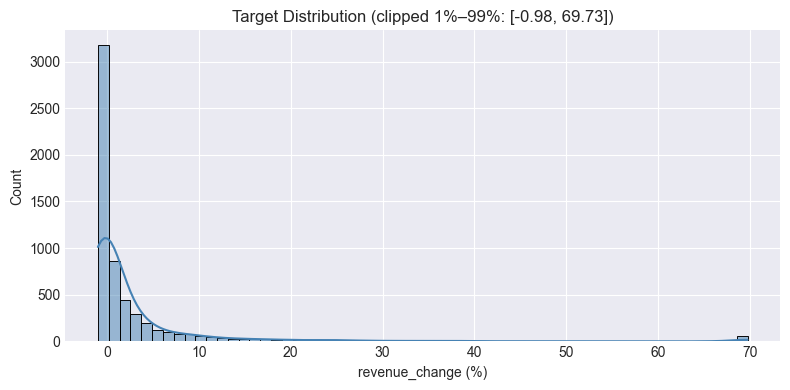

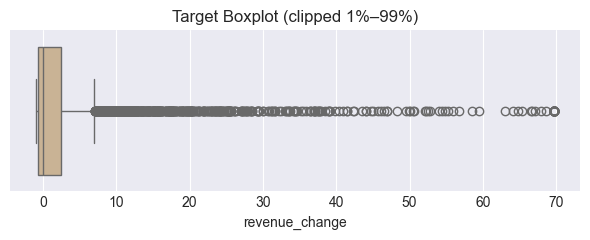

In [31]:
# Target histogram with clipped view (visualization only)
target_series = train_df[target_col].dropna()
lo, hi = clip_bounds(target_series, 0.01, 0.99)

plt.figure(figsize=(8, 4))
sns.histplot(target_series.clip(lo, hi), bins=60, kde=True, color='steelblue')
plt.title(f"Target Distribution (clipped 1%–99%: [{lo:.2f}, {hi:.2f}])")
plt.xlabel(f"{target_col} (%)")
plt.tight_layout()
save_fig('target_hist_clipped')
plt.show()

plt.figure(figsize=(6, 2.5))
sns.boxplot(x=target_series.clip(lo, hi), color='tan')
plt.title('Target Boxplot (clipped 1%–99%)')
plt.tight_layout()
save_fig('target_boxplot_clipped')
plt.show()


**What this shows:** the central mass of the target with heavy tails still present (visual clipping only).
**Why it matters for modeling:** tail risk and heteroskedasticity imply robust losses (MAE/Huber), and possibly log-transforming the target for stability.


### 4. Missingness Overview


Missing Values (non-zero):


,Missing Count,Percentage
revenue_change,2999,33.711781
province,690,7.756295
leverage,35,0.393435
roe,35,0.393435


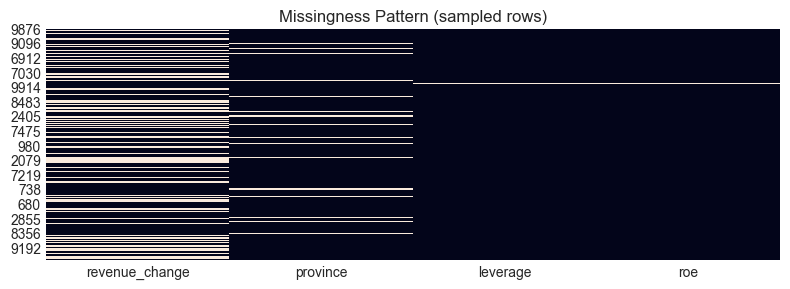

In [32]:
# Missingness table
missing_values = train_df.isnull().sum()
missing_pct = (missing_values / len(train_df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_pct
}).sort_values('Missing Count', ascending=False)

print("Missing Values (non-zero):")
display(missing_df[missing_df['Missing Count'] > 0])

# Missingness pattern heatmap (sampled rows)
missing_cols = missing_df[missing_df['Missing Count'] > 0].index.tolist()
if missing_cols:
    sample = train_df[missing_cols].isna().sample(min(300, len(train_df)), random_state=RANDOM_STATE)
    plt.figure(figsize=(8, 3))
    sns.heatmap(sample, cbar=False)
    plt.title('Missingness Pattern (sampled rows)')
    plt.tight_layout()
    save_fig('missingness_pattern')
    plt.show()


**What this shows:** which columns are incomplete and whether missingness is structured.  
**Why it matters for modeling:** supports targeted imputation and optional missingness indicators.


### 5. Outlier Behavior (Top Skewed Monetary Features)


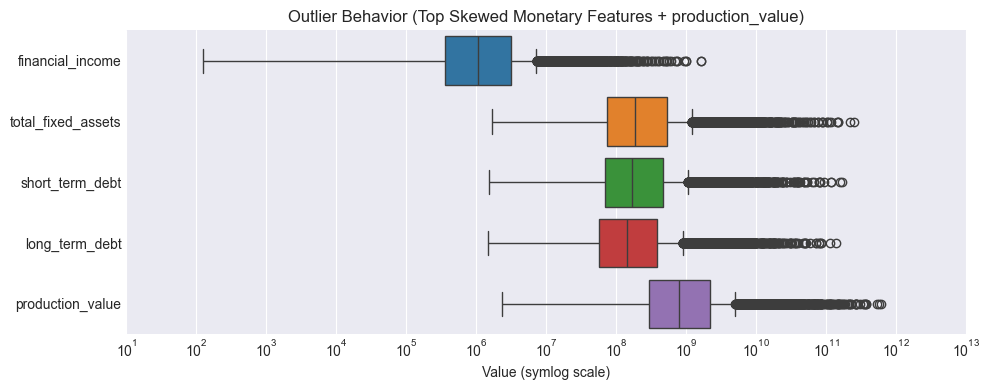

In [33]:
# Outlier behavior via top skewed numeric features (log-scale view for readability)
exclude_cols = ['company_id', 'fiscal_year', target_col, 'bankruptcy_next_year']
num_features = get_numeric_features(train_df, exclude_cols, categorical_like_cols)

# Heuristic: focus on monetary features (exclude ratios)
monetary_like = [c for c in num_features if any(x in c for x in ['assets', 'debt', 'income', 'value', 'costs', 'profit'])]
if len(monetary_like) >= 4:
    top_outlier_cols = top_skewed_features(train_df, monetary_like, k=4)
else:
    top_outlier_cols = top_skewed_features(train_df, num_features, k=4)

# Always include production_value if present
if 'production_value' in num_features and 'production_value' not in top_outlier_cols:
    top_outlier_cols = top_outlier_cols + ['production_value']

plt.figure(figsize=(10, 4))
sns.boxplot(data=train_df[top_outlier_cols], orient='h')
plt.xscale('symlog', linthresh=1.0)

# Clip x-axis to positive range (no space below 0)
lo, hi = clip_bounds(train_df[top_outlier_cols].stack().dropna(), 0.01, 0.99)
plt.xlim(1e1, 1e13)
plt.title('Outlier Behavior (Top Skewed Monetary Features + production_value)')
plt.xlabel('Value (symlog scale)')
plt.tight_layout()
save_fig('outlier_boxplots_top4_symlog')
plt.show()


**What this shows:** tail behavior in core monetary variables without extreme compression.  
**Why it matters for modeling:** motivates robust scaling or tree models that handle heavy tails.


### 6. Representative Numeric Distributions


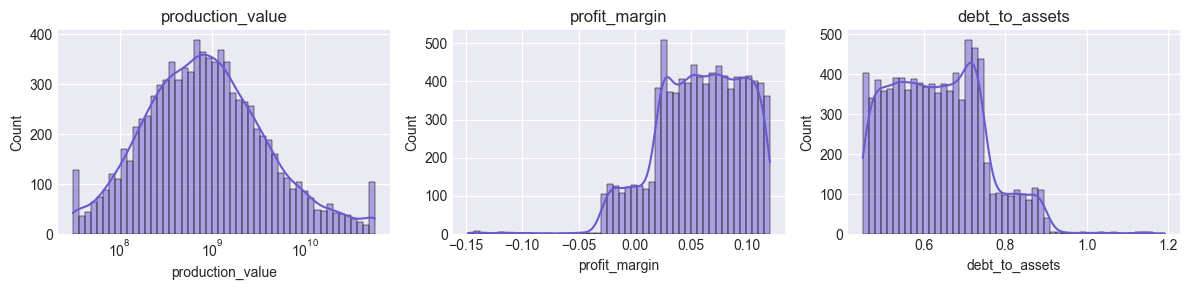

In [34]:
# Representative features: scale (production_value), profitability (profit_margin), leverage (debt_to_assets)
rep_features = [
    c for c in ['production_value', 'profit_margin', 'debt_to_assets']
    if c in train_df.columns
]

fig, axes = plt.subplots(1, len(rep_features), figsize=(4 * len(rep_features), 3))
if len(rep_features) == 1:
    axes = [axes]

for ax, col in zip(axes, rep_features):
    data = train_df[col].dropna()
    if col in ['production_value']:
        data = data.clip(*clip_bounds(data, 0.01, 0.99))
        ax.set_xscale('symlog', linthresh=1.0)
    sns.histplot(data, bins=50, kde=True, ax=ax, color='slateblue')
    ax.set_title(col)

plt.tight_layout()
save_fig('representative_numeric_distributions')
plt.show()


**What this shows:** typical shapes for scale, profitability, and leverage features.  
**Why it matters for modeling:** indicates which variables need scaling or transformation for linear models.


### 7. Multicollinearity Structure


Dropped (scale/total group): ['total_assets', 'shareholders_equity', 'total_debt', 'short_term_debt', 'long_term_debt', 'production_value', 'production_costs', 'financial_expenses', 'net_profit_loss']
Kept (scale/total group): ['total_fixed_assets', 'current_assets', 'operating_income', 'financial_income']
Dropped (ratio group): ['quick_ratio']
Kept (ratio group): ['roe', 'roi', 'profit_margin', 'leverage', 'debt_to_assets', 'current_ratio']


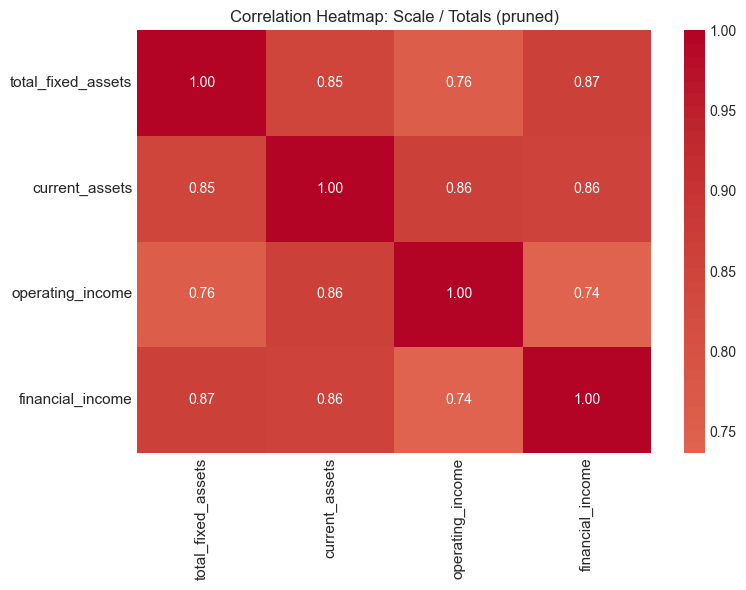

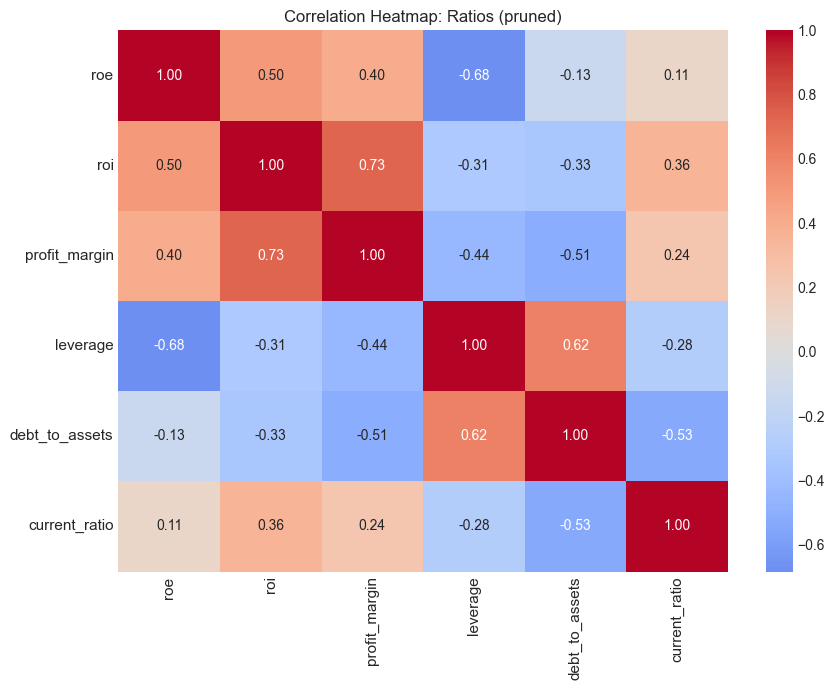

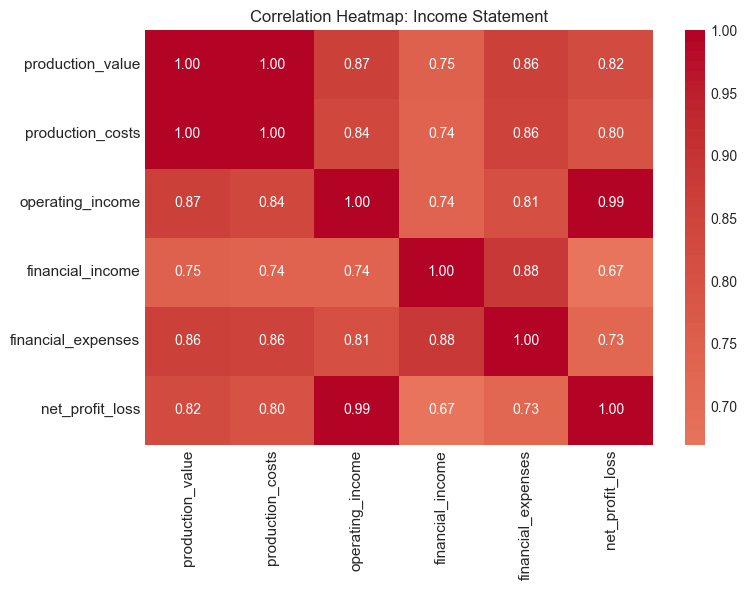

In [35]:
# Correlation heatmaps split into totals vs ratios + drop highly correlated (>|0.90|)
exclude_cols = ['company_id', 'fiscal_year', target_col, 'bankruptcy_next_year']
num_features = get_numeric_features(train_df, exclude_cols, categorical_like_cols)

# Define ratio vs totals groups (adjust if needed)
ratio_features = [
    c for c in ['roe', 'roi', 'profit_margin', 'leverage', 'debt_to_assets', 'current_ratio', 'quick_ratio']
    if c in num_features
]

# Income statement group (core statement line items)
income_statement_candidates = [
    'production_value', 'production_costs', 'operating_income',
    'financial_income', 'financial_expenses', 'net_profit_loss'
]
income_statement_features = [c for c in income_statement_candidates if c in num_features]

scale_features = [c for c in num_features if c not in ratio_features]

# Drop years_in_business explicitly from scale heatmap
scale_features = [c for c in scale_features if c != 'years_in_business']

# Drop highly correlated features within each group (greedy, |corr| > 0.90)

def drop_high_corr(df, cols, threshold=0.90):
    corr = df[cols].corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    drop_cols = [col for col in upper.columns if any(upper[col] > threshold)]
    keep_cols = [c for c in cols if c not in drop_cols]
    return keep_cols, drop_cols, corr

scale_keep, scale_drop, scale_corr = drop_high_corr(train_df, scale_features, threshold=0.90)
ratio_keep, ratio_drop, ratio_corr = drop_high_corr(train_df, ratio_features, threshold=0.90)

print("Dropped (scale/total group):", scale_drop)
print("Kept (scale/total group):", scale_keep)
print("Dropped (ratio group):", ratio_drop)
print("Kept (ratio group):", ratio_keep)

# Heatmap A: Scale/Totals
plt.figure(figsize=(8, 6))
sns.heatmap(train_df[scale_keep].corr(), cmap='coolwarm', center=0, annot=True, fmt='.2f')
plt.title('Correlation Heatmap: Scale / Totals (pruned)')
plt.xticks(fontsize=11, rotation=90)
plt.yticks(fontsize=11, rotation=0)
plt.tight_layout()
save_fig('correlation_heatmap_scale_totals')
plt.show()

# Heatmap B: Ratios
if len(ratio_keep) > 0:
    plt.figure(figsize=(9, 7))
    sns.heatmap(train_df[ratio_keep].corr(), cmap='coolwarm', center=0, annot=True, fmt='.2f')
    plt.title('Correlation Heatmap: Ratios (pruned)')
    plt.xticks(fontsize=11, rotation=90)
    plt.yticks(fontsize=11, rotation=0)
    plt.tight_layout()
    save_fig('correlation_heatmap_ratios')
    plt.show()

# Heatmap C: Income Statement
if len(income_statement_features) > 1:
    plt.figure(figsize=(8, 6))
    sns.heatmap(train_df[income_statement_features].corr(), cmap='coolwarm', center=0, annot=True, fmt='.2f')
    plt.title('Correlation Heatmap: Income Statement')
    plt.xticks(fontsize=11, rotation=90)
    plt.yticks(fontsize=11, rotation=0)
    plt.tight_layout()
    save_fig('correlation_heatmap_income_statement')
    plt.show()


**What this shows:** strong linear dependencies among financial totals and ratios.  
**Why it matters for modeling:** suggests regularization (Ridge/ElasticNet) or tree-based models.


### 8. Feature–Target Relationships (Top 2, Interpretable)


Top 10 numeric features by absolute Spearman correlation with target:


,pearson,spearman
production_value,0.207010,0.559449
production_costs,0.206330,0.558479
total_assets,0.212201,0.546971
current_assets,0.218514,0.545214
total_debt,0.216952,0.541392
short_term_debt,0.212767,0.538221
long_term_debt,0.214357,0.535191
financial_expenses,0.219904,0.530805
shareholders_equity,0.198175,0.527604
total_fixed_assets,0.188815,0.520601


Bottom 10 numeric features by absolute Spearman correlation with target:


,pearson,spearman
financial_income,0.199640,0.451571
net_profit_loss,0.186122,0.440166
roe,0.007434,0.081265
roi,0.021183,0.078636
profit_margin,0.014423,0.009478
debt_to_assets,-0.003651,-0.008878
leverage,-0.006222,-0.007890
years_in_business,0.025078,-0.001334
current_ratio,0.000677,0.000651
quick_ratio,0.000676,0.000648


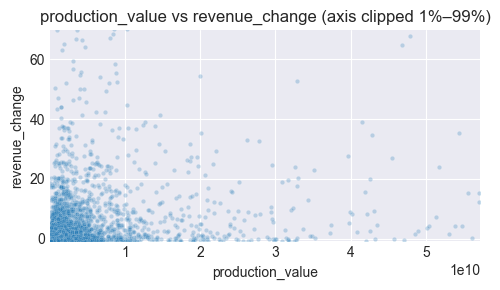

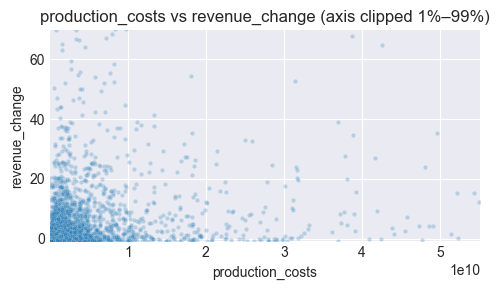

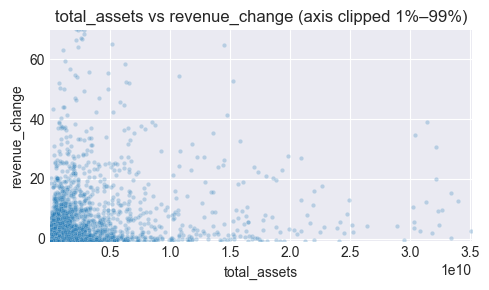

In [36]:
# Correlation of numeric features with target (Pearson and Spearman)
analysis_df = train_df.dropna(subset=[target_col])

numeric_cols = analysis_df.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['company_id', 'fiscal_year', target_col, 'bankruptcy_next_year'] + categorical_like_cols
numeric_features = [c for c in numeric_cols if c not in exclude_cols]

pearson_corr = analysis_df[numeric_features].corrwith(analysis_df[target_col])
spearman_corr = analysis_df[numeric_features].corrwith(analysis_df[target_col], method='spearman')

corr_df = pd.DataFrame({
    'pearson': pearson_corr,
    'spearman': spearman_corr
}).sort_values('spearman', key=lambda s: s.abs(), ascending=False)

print("Top 10 numeric features by absolute Spearman correlation with target:")
display(corr_df.head(10))

print("Bottom 10 numeric features by absolute Spearman correlation with target:")
display(corr_df.tail(10))

# Scatter plots for the top 3 features with axis-only clipping (1%–99%)
for col in corr_df.head(3).index:
    x = analysis_df[col].values
    y = analysis_df[target_col].values

    x_clip = clip_bounds(pd.Series(x), 0.01, 0.99)
    y_clip = clip_bounds(pd.Series(y), 0.01, 0.99)

    plt.figure(figsize=(5, 3))
    sns.scatterplot(data=analysis_df, x=col, y=target_col, alpha=0.25, s=10)
    plt.title(f'{col} vs {target_col} (axis clipped 1%–99%)')
    plt.xlim(x_clip)
    plt.ylim(y_clip)
    plt.tight_layout()
    save_fig(f'feature_target_scatter_{col}')
    plt.show()

# Categorical relationships with target (violin plots for top categories) with y-axis clipping
cat_cols = analysis_df.select_dtypes(include=['object']).columns.tolist()
cat_features = [c for c in cat_cols if c not in ['company_id', 'financial_health_class']]
for c in categorical_like_cols:
    if c not in cat_features:
        cat_features.append(c)



**What this shows:** density concentrates in narrow bands with non‑linear spread and weak conditional shifts.
**Why it matters for modeling:** simple linear fits will underperform; consider log inputs, interaction terms, or tree/boosted models.


### 9. Categorical Signal (Top-N + Other)


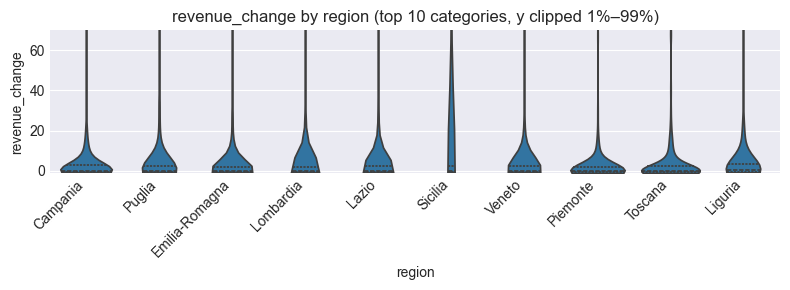

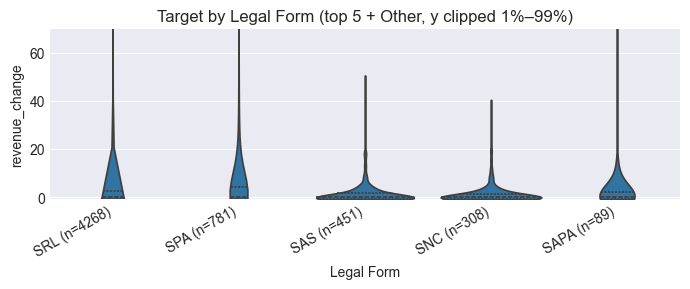

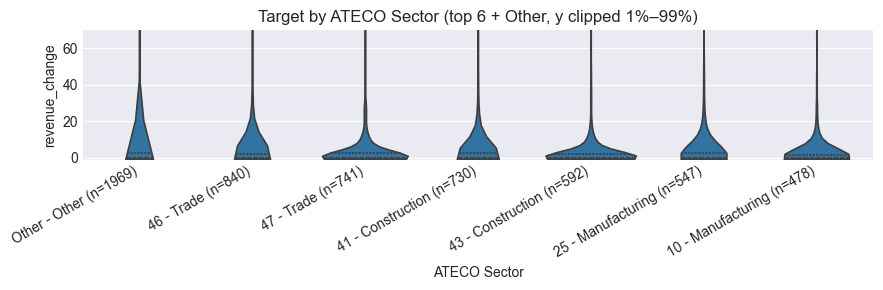

In [37]:
# Compute target clip bounds for consistent y-axis scaling
y_lo, y_hi = clip_bounds(analysis_df[target_col], 0.01, 0.99)

for col in [c for c in [ 'region'] if c in cat_features]:
    top_cats = analysis_df[col].value_counts().head(10).index
    plot_df = analysis_df[analysis_df[col].isin(top_cats)]
    plt.figure(figsize=(8, 3))
    sns.violinplot(data=plot_df, x=col, y=target_col, inner='quartile', cut=0)
    plt.title(f'{target_col} by {col} (top 10 categories, y clipped 1%–99%)')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(y_lo, y_hi)
    plt.tight_layout()
    save_fig(f'target_by_{col}')
    plt.show()
# Analysis: diagnostics only; do not engineer features here to avoid leakage.

# Target by legal_form (top-N + Other) with y-axis clipping and violin plots
if 'legal_form' in train_df.columns:
    plot_df = train_df[[target_col, 'legal_form']].dropna()
    plot_df['legal_form_grouped'] = top_categories_with_other(plot_df, 'legal_form', top_n=5)

    counts = plot_df['legal_form_grouped'].value_counts()
    order = counts.index.tolist()
    labels = [f"{cat} (n={counts[cat]})" for cat in order]

    y_lo, y_hi = clip_bounds(plot_df[target_col], 0.01, 0.99)

    plt.figure(figsize=(7, 3))
    sns.violinplot(data=plot_df, x='legal_form_grouped', y=target_col, order=order, inner='quartile', cut=0)
    plt.title('Target by Legal Form (top 5 + Other, y clipped 1%–99%)')
    plt.xlabel('Legal Form')
    plt.ylabel(target_col)
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=30, ha='right')
    plt.ylim(y_lo, y_hi)
    plt.tight_layout()
    save_fig('target_by_legal_form')
    plt.show()

# Target by ateco_sector (top-N + Other) with y-axis clipping and violin plots
if 'ateco_sector' in train_df.columns:
    plot_df = train_df[[target_col, 'ateco_sector']].dropna()
    plot_df['ateco_sector_grouped'] = top_categories_with_other(plot_df, 'ateco_sector', top_n=6)

    # ATECO 2-digit sector name mapping (compact, for labels)
    def ateco_name(code):
        try:
            c = int(str(code))
        except Exception:
            return 'Other'
        if 1 <= c <= 3:
            return 'Agriculture'
        if 5 <= c <= 9:
            return 'Mining'
        if 10 <= c <= 33:
            return 'Manufacturing'
        if c == 35:
            return 'Utilities'
        if 36 <= c <= 39:
            return 'Water/Waste'
        if 41 <= c <= 43:
            return 'Construction'
        if 45 <= c <= 47:
            return 'Trade'
        if 49 <= c <= 53:
            return 'Transport'
        if 55 <= c <= 56:
            return 'Accommodation/Food'
        if 58 <= c <= 63:
            return 'Info/Comm'
        if 64 <= c <= 66:
            return 'Finance/Insurance'
        if c == 68:
            return 'Real Estate'
        if 69 <= c <= 75:
            return 'Prof/Tech'
        if 77 <= c <= 82:
            return 'Admin/Support'
        if c == 84:
            return 'Public Admin'
        if c == 85:
            return 'Education'
        if 86 <= c <= 88:
            return 'Health/Social'
        if 90 <= c <= 93:
            return 'Arts/Rec'
        if 94 <= c <= 96:
            return 'Other Services'
        return 'Other'

    counts = plot_df['ateco_sector_grouped'].value_counts()
    order = counts.index.tolist()
    labels = [f"{code} - {ateco_name(code)} (n={counts[code]})" for code in order]

    y_lo, y_hi = clip_bounds(plot_df[target_col], 0.01, 0.99)

    plt.figure(figsize=(9, 3))
    sns.violinplot(data=plot_df, x='ateco_sector_grouped', y=target_col, order=order, inner='quartile', cut=0)
    plt.title('Target by ATECO Sector (top 6 + Other, y clipped 1%–99%)')
    plt.xlabel('ATECO Sector')
    plt.ylabel(target_col)
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=30, ha='right')
    plt.ylim(y_lo, y_hi)
    plt.tight_layout()
    save_fig('target_by_ateco_sector')
    plt.show()


**What this shows:** category medians differ, but IQR overlap is substantial in several groups.
**Why it matters for modeling:** categories carry signal but require robust encoding; tree models may capture cross‑effects better than linear baselines.


### 10. Leakage Audit (Mandatory)


In [38]:
# Identify suspicious columns that may contain future or post-event info
suspicious_patterns = ['next', 'future', 'after', 't+1', 'post']
flagged_cols = [
    c for c in train_df.columns
    if any(p in c.lower() for p in suspicious_patterns)
]

# Explicit known leakage targets
explicit_leakage = ['bankruptcy_next_year', 'financial_health_class']
flagged = sorted(set(flagged_cols + [c for c in explicit_leakage if c in train_df.columns]))

print("Flagged potential leakage columns:")
print(flagged)

print("\nLeakage prevention steps:")
print("- Exclude flagged columns from feature lists.")
print("- Use temporal splits by fiscal_year to avoid future information.")
print("- Do not engineer features using target values.")
print("- Use transformations only for visualization; no target-conditioned filtering.")


Flagged potential leakage columns:
['bankruptcy_next_year', 'financial_health_class']

Leakage prevention steps:
- Exclude flagged columns from feature lists.
- Use temporal splits by fiscal_year to avoid future information.
- Do not engineer features using target values.
- Use transformations only for visualization; no target-conditioned filtering.


**What this shows:** explicit audit of risky columns and safeguards.  
**Why it matters for modeling:** ensures evaluation integrity and prevents leakage-driven optimism.


### Key EDA Conclusions (Lean Summary)


- Target is heavy‑tailed and skewed; robust losses or transforms are likely necessary.
- Missingness is limited to a few columns, supporting focused imputation.
- Monetary features show extreme outliers; robust scaling or tree models are preferred.
- Strong multicollinearity exists among balance sheet totals; regularization is advisable.
- Legal form and sector show categorical signal worth encoding.
- Leakage risk is controlled by explicit exclusions and temporal splits.


## 3. Data Preprocessing

Handle missing values, outliers, and prepare data for modeling.

### Leakage-Safe Cleaning Pipeline (Challenge 3: revenue_change_next_year)

This pipeline follows a strict **no-leakage** discipline:
- **Row-wise cleaning** (types, identities, negatives, ratio validity) happens before splitting.
- **Statistical transforms** (imputation, winsorization, outlier thresholds, scaling) are **fit on TRAIN only** and applied to val/test.
- **Feature engineering** uses only current/past data within each company.
- **Target** is defined as **next-year revenue change** to avoid same-year leakage.


In [39]:
# --- Configuration ---
TARGET_COL = 'revenue_change_next_year'  # leakage-safe target (t+1)
EPS = 1e-9
NEG_CLIP_TOL = 1e-6  # treat tiny negatives as rounding
REV_CHANGE_CAP_LO = -0.70  # cap extreme YoY revenue change (lower)
REV_CHANGE_CAP_HI = 1.00   # cap extreme YoY revenue change (upper)
NEAR_ZERO_THR = 0.25  # threshold for near-zero targets (percentage points)

RAW_ITEMS = [
    'total_fixed_assets', 'current_assets', 'total_assets',
    'shareholders_equity', 'total_debt', 'short_term_debt', 'long_term_debt',
    'production_value', 'production_costs', 'operating_income',
    'financial_income', 'financial_expenses', 'net_profit_loss'
]

RATIO_COLS = [
    'roe', 'roi', 'leverage', 'current_ratio', 'quick_ratio',
    'debt_to_assets', 'profit_margin'
]

NONNEG_COLS = [
    'total_fixed_assets', 'current_assets', 'total_assets',
    'total_debt', 'short_term_debt', 'long_term_debt',
    'production_value', 'production_costs',
    'financial_income', 'financial_expenses'
]

ID_COLS = ['company_id', 'fiscal_year']
LEAKAGE_COLS = ['bankruptcy_next_year', 'financial_health_class', 'revenue_change']

VALID_LEGAL_FORMS = {'SRL', 'SPA', 'SAPA', 'SAS', 'SNC'}

def std_str(s):
    return (
        s.astype('string')
         .str.strip()
         .str.upper()
         .replace({'': pd.NA, 'NAN': pd.NA, 'NONE': pd.NA})
    )

def standardize_legal_form(series):
    if series is None:
        return series, None
    s = std_str(series)
    repl = {
        'S.R.L.': 'SRL', 'S R L': 'SRL', 'SRL': 'SRL',
        'S.P.A.': 'SPA', 'S P A': 'SPA', 'SPA': 'SPA',
        'S.A.P.A.': 'SAPA', 'S A P A': 'SAPA', 'SAPA': 'SAPA',
        'S.A.S.': 'SAS', 'S A S': 'SAS', 'SAS': 'SAS',
        'S.N.C.': 'SNC', 'S N C': 'SNC', 'SNC': 'SNC'
    }
    s = s.replace(repl)
    is_other = ~s.isin(list(VALID_LEGAL_FORMS))
    s = s.where(~is_other, other='OTHER/UNKNOWN')
    return s, is_other.astype(int)

def safe_divide(a, b, eps=EPS):
    b_safe = b.where(~b.isna(), other=np.nan)
    return a / (b_safe.replace({0: np.nan}) + 0.0)

def resolve_duplicates(df, key_cols):
    dup_mask = df.duplicated(key_cols, keep=False)
    if not dup_mask.any():
        return df, 0
    tmp = df.copy()
    tmp['_non_nulls'] = tmp.notna().sum(axis=1)
    tmp = tmp.sort_values(key_cols + ['_non_nulls'], ascending=[True, True, False])
    deduped = tmp.drop_duplicates(key_cols, keep='first').drop(columns=['_non_nulls'])
    return deduped, int(dup_mask.sum())

def check_identity(lhs, rhs, tol=1e-3):
    diff = (lhs - rhs).abs()
    scale = np.maximum(1.0, lhs.abs())
    return diff <= tol * scale

def apply_accounting_fixes(df):
    df = df.copy()
    cols = df.columns

    # Fill totals from components when totals are missing
    if {'total_fixed_assets', 'current_assets', 'total_assets'} <= set(cols):
        mask = df['total_assets'].isna() & df['total_fixed_assets'].notna() & df['current_assets'].notna()
        df.loc[mask, 'total_assets'] = df.loc[mask, 'total_fixed_assets'] + df.loc[mask, 'current_assets']

    if {'short_term_debt', 'long_term_debt', 'total_debt'} <= set(cols):
        mask = df['total_debt'].isna() & df['short_term_debt'].notna() & df['long_term_debt'].notna()
        df.loc[mask, 'total_debt'] = df.loc[mask, 'short_term_debt'] + df.loc[mask, 'long_term_debt']

    # Identity checks
    a_ok = pd.Series(False, index=df.index)
    b_ok = pd.Series(False, index=df.index)
    c_ok = pd.Series(False, index=df.index)

    if {'total_assets', 'total_fixed_assets', 'current_assets'} <= set(cols):
        a_ok = check_identity(df['total_assets'], df['total_fixed_assets'] + df['current_assets'])
    if {'total_debt', 'short_term_debt', 'long_term_debt'} <= set(cols):
        b_ok = check_identity(df['total_debt'], df['short_term_debt'] + df['long_term_debt'])
    if {'total_assets', 'shareholders_equity', 'total_debt'} <= set(cols):
        c_ok = check_identity(df['total_assets'], df['shareholders_equity'] + df['total_debt'])

    # If A & B pass but C fails, derive equity
    if {'total_assets', 'shareholders_equity', 'total_debt'} <= set(cols):
        mask = a_ok & b_ok & (~c_ok) & df['total_assets'].notna() & df['total_debt'].notna()
        df.loc[mask, 'shareholders_equity'] = df.loc[mask, 'total_assets'] - df.loc[mask, 'total_debt']

    # Recompute checks after fixes
    if {'total_assets', 'total_fixed_assets', 'current_assets'} <= set(cols):
        a_ok = check_identity(df['total_assets'], df['total_fixed_assets'] + df['current_assets'])
    if {'total_debt', 'short_term_debt', 'long_term_debt'} <= set(cols):
        b_ok = check_identity(df['total_debt'], df['short_term_debt'] + df['long_term_debt'])
    if {'total_assets', 'shareholders_equity', 'total_debt'} <= set(cols):
        c_ok = check_identity(df['total_assets'], df['shareholders_equity'] + df['total_debt'])

    df['identity_A_ok'] = a_ok.astype(int)
    df['identity_B_ok'] = b_ok.astype(int)
    df['identity_C_ok'] = c_ok.astype(int)
    df['accounting_identity_violation'] = (~a_ok | ~b_ok | ~c_ok).astype(int)
    return df

def apply_negative_rules(df, cols):
    df = df.copy()
    for c in cols:
        if c not in df.columns:
            continue
        neg_mask = df[c] < -NEG_CLIP_TOL
        small_neg = (df[c] >= -NEG_CLIP_TOL) & (df[c] < 0)
        df.loc[small_neg, c] = 0
        df.loc[neg_mask, c] = np.nan
        df[f'neg_{c}'] = neg_mask.astype(int)
    return df

def add_ratio_flags(df):
    df = df.copy()
    # Replace inf with NaN for ratio columns
    ratio_cols = [c for c in RATIO_COLS if c in df.columns]
    if ratio_cols:
        df[ratio_cols] = df[ratio_cols].replace([np.inf, -np.inf], np.nan)

    # Invalid ratio conditions (denominator <= 0)
    if 'roe' in df.columns and 'shareholders_equity' in df.columns:
        df['roe_invalid'] = (df['shareholders_equity'] <= 0).astype(int)
    if 'roi' in df.columns and 'total_assets' in df.columns:
        df['roi_invalid'] = (df['total_assets'] <= 0).astype(int)
    if 'profit_margin' in df.columns and 'production_value' in df.columns:
        df['profit_margin_invalid'] = (df['production_value'] <= 0).astype(int)
    if 'current_ratio' in df.columns and 'short_term_debt' in df.columns:
        df['current_ratio_invalid'] = (df['short_term_debt'] <= 0).astype(int)
    if 'quick_ratio' in df.columns and 'short_term_debt' in df.columns:
        df['quick_ratio_invalid'] = (df['short_term_debt'] <= 0).astype(int)
    if 'debt_to_assets' in df.columns and 'total_assets' in df.columns:
        df['debt_to_assets_invalid'] = (df['total_assets'] <= 0).astype(int)
    if 'leverage' in df.columns and 'shareholders_equity' in df.columns:
        df['leverage_invalid'] = (df['shareholders_equity'] <= 0).astype(int)
    return df

def add_missing_indicators(df, cols):
    df = df.copy()
    for c in cols:
        if c in df.columns:
            df[f'is_missing_{c}'] = df[c].isna().astype(int)
    return df


In [40]:
# --- Step 1-7: Panel sanity, types, accounting, ratios, missing flags ---
df_clean = full_df.copy()

# Types
df_clean['company_id'] = df_clean['company_id'].astype(str)
df_clean['fiscal_year'] = pd.to_numeric(df_clean['fiscal_year'], errors='coerce').astype('Int64')

# Standardize categoricals
for col in ['province', 'region']:
    if col in df_clean.columns:
        df_clean[col] = std_str(df_clean[col])

if 'ateco_sector' in df_clean.columns:
    df_clean['ateco_sector'] = df_clean['ateco_sector'].astype('Int64').astype('string')
    df_clean['ateco_sector'] = df_clean['ateco_sector'].str.zfill(2).fillna('UNKNOWN')

if 'legal_form' in df_clean.columns:
    df_clean['legal_form'], df_clean['legal_form_is_other'] = standardize_legal_form(df_clean['legal_form'])

# Resolve duplicate (company_id, fiscal_year)
df_clean, dup_rows = resolve_duplicates(df_clean, ['company_id', 'fiscal_year'])
print(f'Duplicate rows detected (pre-resolve): {dup_rows}')

# Accounting identities
df_clean = apply_accounting_fixes(df_clean)

# Negative value rules
df_clean = apply_negative_rules(df_clean, NONNEG_COLS)

# Ratio validity + inf handling
df_clean = add_ratio_flags(df_clean)

# Missingness indicators (raw + ratio + years_in_business)
missing_cols = [c for c in RAW_ITEMS + RATIO_COLS + ['years_in_business'] if c in df_clean.columns]
df_clean = add_missing_indicators(df_clean, missing_cols)

# --- Step 8-11: Feature engineering + target alignment (leakage-safe) ---
df_clean = df_clean.sort_values(['company_id', 'fiscal_year']).copy()

# COVID dummy (2020-2021)
if 'fiscal_year' in df_clean.columns:
    df_clean['is_covid_year'] = df_clean['fiscal_year'].isin([2020, 2021]).astype(int)

# Recompute revenue_change from production_value (t vs t-1), then shift for target
if 'production_value' in df_clean.columns:
    pv_lag1 = df_clean.groupby('company_id')['production_value'].shift(1)
    df_clean['revenue_change_clean'] = np.where(pv_lag1 > 0, (df_clean['production_value'] - pv_lag1) / pv_lag1, np.nan)

# Flag extreme YoY revenue changes (likely M&A / extraordinary events)
if 'revenue_change_clean' in df_clean.columns:
    df_clean['is_extreme_revenue_change'] = ((df_clean['revenue_change_clean'] < REV_CHANGE_CAP_LO) | (df_clean['revenue_change_clean'] > REV_CHANGE_CAP_HI)).astype(int)
    df_clean['revenue_change_capped'] = df_clean['revenue_change_clean'].clip(REV_CHANGE_CAP_LO, REV_CHANGE_CAP_HI)
else:
    df_clean['revenue_change_clean'] = df_clean.get('revenue_change', np.nan)

df_clean[TARGET_COL] = df_clean.groupby('company_id')['revenue_change_capped'].shift(-1)

# Lag/YoY/Growth features
lag_base = [c for c in RAW_ITEMS + RATIO_COLS + ['revenue_change_clean'] if c in df_clean.columns]
for c in lag_base:
    df_clean[f'{c}_lag1'] = df_clean.groupby('company_id')[c].shift(1)
    df_clean[f'{c}_lag2'] = df_clean.groupby('company_id')[c].shift(2)

growth_cols = [c for c in RAW_ITEMS if c in df_clean.columns]
for c in growth_cols:
    lag1 = df_clean.groupby('company_id')[c].shift(1)
    df_clean[f'{c}_yoy_change'] = df_clean[c] - lag1
    df_clean[f'{c}_yoy_pct'] = (df_clean[c] - lag1) / (lag1.abs() + EPS)

# Rolling features (past only)
roll_cols = [c for c in ['production_value', 'operating_income', 'total_assets', 'total_debt', 'net_profit_loss'] if c in df_clean.columns]
for c in roll_cols:
    df_clean[f'{c}_roll3_mean'] = (
        df_clean.groupby('company_id')[c]
               .rolling(window=3, min_periods=2)
               .mean()
               .reset_index(level=0, drop=True)
    )
    df_clean[f'{c}_roll3_std'] = (
        df_clean.groupby('company_id')[c]
               .rolling(window=3, min_periods=2)
               .std()
               .reset_index(level=0, drop=True)
    )

# Derived indicators (current-year only)
if {'operating_income', 'production_value'} <= set(df_clean.columns):
    df_clean['operating_margin'] = safe_divide(df_clean['operating_income'], df_clean['production_value'])
if {'net_profit_loss', 'production_value'} <= set(df_clean.columns):
    df_clean['net_margin'] = safe_divide(df_clean['net_profit_loss'], df_clean['production_value'])
if {'production_value', 'total_assets'} <= set(df_clean.columns):
    df_clean['asset_turnover'] = safe_divide(df_clean['production_value'], df_clean['total_assets'])
if {'shareholders_equity', 'total_assets'} <= set(df_clean.columns):
    df_clean['equity_ratio'] = safe_divide(df_clean['shareholders_equity'], df_clean['total_assets'])
if {'total_debt', 'shareholders_equity'} <= set(df_clean.columns):
    df_clean['debt_to_equity'] = safe_divide(df_clean['total_debt'], df_clean['shareholders_equity'])
if {'current_assets', 'short_term_debt'} <= set(df_clean.columns):
    df_clean['working_capital'] = df_clean['current_assets'] - df_clean['short_term_debt']
    if 'total_assets' in df_clean.columns:
        df_clean['working_capital_ratio'] = safe_divide(df_clean['working_capital'], df_clean['total_assets'])

# Final modeling dataset (drop rows without target)
df_model = df_clean[df_clean[TARGET_COL].notna()].copy()
print(f'Rows after target alignment: {df_model.shape[0]}')
print(f'Year range: {df_model.fiscal_year.min()} - {df_model.fiscal_year.max()}')
print('Identity violations:', df_model['accounting_identity_violation'].sum())

# Keep compatibility with downstream cells
target_col = TARGET_COL
df_processed = df_model.copy()


Duplicate rows detected (pre-resolve): 0
Rows after target alignment: 8829
Year range: 2018 - 2020
Identity violations: 0


In [41]:
# --- Step 12: Time split (leakage-safe) ---
years = sorted(df_model['fiscal_year'].dropna().unique())
preferred_train = [2018, 2019, 2020]
preferred_val = [2021]
preferred_test = [2022, 2023]

# Use preferred split if all preferred years exist after target alignment
if set(preferred_train + preferred_val + preferred_test).issubset(set(years)):
    train_years = preferred_train
    val_years = preferred_val
    test_years = preferred_test
else:
    # Dynamic fallback with more training data when years are limited
    if len(years) >= 4:
        train_years = years[:-2]
        val_years = [years[-2]]
        test_years = [years[-1]]
    elif len(years) == 3:
        train_years = years[:2]
        val_years = [years[2]]
        test_years = []
    elif len(years) == 2:
        train_years = [years[0]]
        val_years = [years[1]]
        test_years = []
    else:
        train_years = years
        val_years = []
        test_years = []

df_train = df_model[df_model['fiscal_year'].isin(train_years)].copy()
df_val = df_model[df_model['fiscal_year'].isin(val_years)].copy()
df_test = df_model[df_model['fiscal_year'].isin(test_years)].copy() if test_years else None

print('Split years ->', 'train', train_years, 'val', val_years, 'test', test_years)
print('Shapes ->', df_train.shape, df_val.shape, (df_test.shape if df_test is not None else None))

# --- Step 6-8: Impute, winsorize, outlier flags, log1p (fit on TRAIN only) ---

# Identify feature columns
drop_cols = ID_COLS + LEAKAGE_COLS + [TARGET_COL]
if 'province' in df_train.columns:
    drop_cols = drop_cols + ['province']

# Categorical features (province is dropped by default to avoid high cardinality)
cat_cols = [c for c in ['ateco_sector', 'region', 'legal_form', 'fiscal_year'] if c in df_train.columns]
# Keep fiscal_year as a feature if we include it as categorical
if 'fiscal_year' in cat_cols and 'fiscal_year' in drop_cols:
    drop_cols = [c for c in drop_cols if c != 'fiscal_year']

# Collapse rare categories using TRAIN only
def collapse_rare(train, df, col, min_count=50):
    if col not in train.columns or col not in df.columns:
        return df
    vc = train[col].value_counts(dropna=False)
    keep = vc[vc >= min_count].index
    # Ensure we can safely assign 'OTHER' even for numeric dtypes
    df[col] = df[col].astype('string')
    df[col] = df[col].where(df[col].isin(keep.astype('string')), other='OTHER')
    return df

for c in cat_cols:
    df_train = collapse_rare(df_train, df_train, c, min_count=50)
    df_val = collapse_rare(df_train, df_val, c, min_count=50)
    if df_test is not None:
        df_test = collapse_rare(df_train, df_test, c, min_count=50)

# Numeric columns to impute/winsorize
num_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in drop_cols]
num_cols = [c for c in num_cols if not c.startswith('is_missing_') and not c.endswith('_invalid') and not c.endswith('_violation') and not c.startswith('neg_')]

# Group median imputation (train-only stats)
group_cols = [c for c in ['ateco_sector', 'region'] if c in df_train.columns]
global_median = df_train[num_cols].median(numeric_only=True)

if group_cols:
    group_medians = df_train.groupby(group_cols)[num_cols].median(numeric_only=True)
    group_index_train = pd.MultiIndex.from_frame(df_train[group_cols])
    group_index_val = pd.MultiIndex.from_frame(df_val[group_cols]) if not df_val.empty else None
    group_index_test = pd.MultiIndex.from_frame(df_test[group_cols]) if df_test is not None else None
else:
    group_medians = None
    group_index_train = group_index_val = group_index_test = None

year_medians = df_train.groupby('fiscal_year')[num_cols].median(numeric_only=True) if 'fiscal_year' in df_train.columns else None

def impute_df(df, group_medians, group_index, year_medians, global_median):
    df = df.copy()
    if group_medians is not None and group_index is not None:
        for c in num_cols:
            df[c] = df[c].fillna(pd.Series(group_index.map(group_medians[c]), index=df.index))
    if year_medians is not None and 'fiscal_year' in df.columns:
        for c in num_cols:
            df[c] = df[c].fillna(df['fiscal_year'].map(year_medians[c]))
    df[num_cols] = df[num_cols].fillna(global_median)
    return df

df_train = impute_df(df_train, group_medians, group_index_train, year_medians, global_median)
df_val = impute_df(df_val, group_medians, group_index_val, year_medians, global_median)
if df_test is not None:
    df_test = impute_df(df_test, group_medians, group_index_test, year_medians, global_median)

# Final safety fill for any remaining missing values in numeric features
for _df in [df_train, df_val] + ([df_test] if df_test is not None else []):
    if _df is None or _df.empty:
        continue
    _df[num_cols] = _df[num_cols].fillna(global_median)

# Winsorization bounds (train-only)
def fit_winsor_bounds(df, cols, lower=0.01, upper=0.99):
    bounds = {}
    for c in cols:
        s = df[c].dropna()
        if s.empty:
            continue
        bounds[c] = (s.quantile(lower), s.quantile(upper))
    return bounds

winsor_bounds = fit_winsor_bounds(df_train, num_cols, lower=0.01, upper=0.99)

# Outlier flags (train-only bounds) - compute BEFORE clipping
def add_outlier_flags(df, bounds):
    df = df.copy()
    for c, (lo, hi) in bounds.items():
        df[f'is_outlier_{c}'] = ((df[c] < lo) | (df[c] > hi)).astype(int)
    return df

df_train = add_outlier_flags(df_train, winsor_bounds)
df_val = add_outlier_flags(df_val, winsor_bounds)
if df_test is not None:
    df_test = add_outlier_flags(df_test, winsor_bounds)

def apply_winsor(df, bounds):
    df = df.copy()
    for c, (lo, hi) in bounds.items():
        df[c] = df[c].clip(lo, hi)
    return df

df_train = apply_winsor(df_train, winsor_bounds)
df_val = apply_winsor(df_val, winsor_bounds)
if df_test is not None:
    df_test = apply_winsor(df_test, winsor_bounds)

# Log1p transforms for non-negative scale variables
LOG_COLS = [c for c in ['total_assets', 'total_fixed_assets', 'current_assets', 'total_debt',
                        'short_term_debt', 'long_term_debt', 'production_value', 'production_costs']
           if c in df_train.columns]

def add_log1p(df, cols):
    df = df.copy()
    for c in cols:
        df[f'log1p_{c}'] = np.log1p(df[c].clip(lower=0))
    return df

df_train = add_log1p(df_train, LOG_COLS)
df_val = add_log1p(df_val, LOG_COLS)
if df_test is not None:
    df_test = add_log1p(df_test, LOG_COLS)

# --- Final feature matrices (one-hot encode categoricals) ---
# Ensure categoricals have no missing values before one-hot
for _df in [df_train, df_val] + ([df_test] if df_test is not None else []):
    if _df is None or _df.empty:
        continue
    for c in cat_cols:
        if c in _df.columns:
            _df[c] = _df[c].astype('string').fillna('OTHER')

feature_cols = [c for c in df_train.columns if c not in drop_cols]

X_train = pd.get_dummies(df_train[feature_cols], columns=cat_cols, drop_first=False)
X_val = pd.get_dummies(df_val[feature_cols], columns=cat_cols, drop_first=False)
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

X_test = None
if df_test is not None:
    X_test = pd.get_dummies(df_test[feature_cols], columns=cat_cols, drop_first=False)
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

y_train = df_train[TARGET_COL].copy()
y_val = df_val[TARGET_COL].copy()
y_test = df_test[TARGET_COL].copy() if df_test is not None else None

print('Final matrices:')
print('X_train', X_train.shape, 'y_train', y_train.shape)
print('X_val', X_val.shape, 'y_val', y_val.shape)
print('X_test', X_test.shape if X_test is not None else None)

# Optional robust scaling for linear models (fit on train only)
from sklearn.preprocessing import RobustScaler

num_cols_model = [c for c in X_train.columns if c in num_cols]  # scale only original numeric cols
scaler = RobustScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_train_scaled[num_cols_model] = scaler.fit_transform(X_train[num_cols_model])
X_val_scaled[num_cols_model] = scaler.transform(X_val[num_cols_model])

if X_test is not None:
    X_test_scaled = X_test.copy()
    X_test_scaled[num_cols_model] = scaler.transform(X_test[num_cols_model])
else:
    X_test_scaled = None

print('Scaled matrices ready (X_train_scaled, X_val_scaled, X_test_scaled).')


Split years -> train [2018, 2019] val [2020] test []
Shapes -> (5897, 163) (2932, 163) None
Final matrices:
X_train (5897, 286) y_train (5897,)
X_val (2932, 286) y_val (2932,)
X_test None
Scaled matrices ready (X_train_scaled, X_val_scaled, X_test_scaled).


In [42]:
# Leakage audit (sanity checks)
import numpy as np

# 1) Confirm no explicit future-shifted features
future_cols = [c for c in df_model.columns if 'lag-1' in c or 'lead' in c or 'shift(-' in c]
print('Potential future/lead columns (name-based):', future_cols)

# 2) Check correlations with future-shifted versions (if possible)
audit_cols = [c for c in df_model.columns if c not in ['company_id', 'fiscal_year', target_col]]
audit_cols = [c for c in audit_cols if df_model[c].dtype != 'object' and not str(df_model[c].dtype).startswith('string')]

# Build a future-shifted copy for a subset of numeric cols
future_shift_corr = []
for c in audit_cols:
    if c not in df_model.columns:
        continue
    future = df_model.groupby('company_id')[c].shift(-1)
    # Correlate target with future value; high correlation is suspicious
    if future.notna().sum() > 100:
        y_num = pd.to_numeric(df_model[target_col], errors='coerce')
        f_num = pd.to_numeric(future, errors='coerce')
        mask = y_num.notna() & f_num.notna()
        if mask.sum() > 100:
            corr = np.corrcoef(y_num[mask], f_num[mask])[0, 1]
            future_shift_corr.append((c, corr))

future_shift_corr = sorted(future_shift_corr, key=lambda x: abs(x[1]), reverse=True)
print('Top 10 correlations between target and future-shifted features:')
for name, corr in future_shift_corr[:10]:
    print(f'{name}: {corr:.3f}')

# 3) Flag suspicious columns (|corr| > 0.4)
suspects = [name for name, corr in future_shift_corr if abs(corr) > 0.4]
print('Suspicious (|corr| > 0.4):', suspects)


Potential future/lead columns (name-based): []
Top 10 correlations between target and future-shifted features:
production_value_yoy_change: 0.251
production_costs_yoy_change: 0.251
shareholders_equity_yoy_pct: 0.230
current_assets_yoy_change: 0.227
total_assets_yoy_change: 0.222
current_assets_yoy_pct: 0.221
total_assets_yoy_pct: 0.220
total_debt_yoy_change: 0.220
long_term_debt_yoy_pct: 0.219
operating_income_yoy_change: 0.217
Suspicious (|corr| > 0.4): ['revenue_change_capped']


## 5. Model Development

Train multiple models and compare performance.

In [43]:
# Import models
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    f1_score, roc_auc_score, accuracy_score,
    mean_squared_error, mean_absolute_error, r2_score
)
from xgboost import XGBClassifier, XGBRegressor

# For handling class imbalance (Challenges 1 & 2)
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

print("Model libraries imported!")

Model libraries imported!


In [44]:
# Prepare X and y (use processed matrices)

# Feature columns are all columns after preprocessing (excluding target/leakage already handled)
feature_cols = X_train.columns.tolist()

X_train = X_train.copy()
y_train = y_train.copy()
X_val = X_val.copy()
y_val = y_val.copy()
if X_test is not None:
    X_test = X_test.copy()
if y_test is not None:
    y_test = y_test.copy()

print('Data prepared for modeling!')
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_val: {X_val.shape}, y_val: {y_val.shape}')
if X_test is not None and y_test is not None:
    print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')
elif X_test is not None and y_test is None:
    print(f'X_test: {X_test.shape}, y_test: None (external test set without target)')
else:
    print('X_test: None, y_test: None')


Data prepared for modeling!
X_train: (5897, 286), y_train: (5897,)
X_val: (2932, 286), y_val: (2932,)
X_test: None, y_test: None


### Baseline Model

In [45]:
# Baseline Model (Linear Regression) with Group-Median Imputer + One-Hot Encoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Use raw splits (before one-hot) but after leakage-safe feature engineering
base_train = df_train.copy()
base_val = df_val.copy()

target_col = target_col  # already set in preprocessing
leakage_cols = ['company_id', 'bankruptcy_next_year', 'financial_health_class', target_col]

class GroupMedianImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_cols, num_cols):
        self.group_cols = group_cols
        self.num_cols = num_cols
        self.group_medians_ = None
        self.global_median_ = None

    def fit(self, X, y=None):
        X = X.copy()
        self.global_median_ = X[self.num_cols].median(numeric_only=True)
        if self.group_cols:
            self.group_medians_ = X.groupby(self.group_cols)[self.num_cols].median(numeric_only=True)
        else:
            self.group_medians_ = None
        return self

    def transform(self, X):
        X = X.copy()
        if self.group_cols and self.group_medians_ is not None:
            group_index = pd.MultiIndex.from_frame(X[self.group_cols])
            for c in self.num_cols:
                X[c] = X[c].fillna(pd.Series(group_index.map(self.group_medians_[c]), index=X.index))
        X[self.num_cols] = X[self.num_cols].fillna(self.global_median_)
        return X

# Define columns
cat_cols = [c for c in ['ateco_sector', 'legal_form', 'region', 'fiscal_year'] if c in base_train.columns]
num_cols = base_train.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in leakage_cols]

# Group-based imputation uses sector/legal_form/region when available
group_cols = [c for c in ['ateco_sector', 'legal_form', 'region'] if c in base_train.columns]

# Build preprocessing pipeline
numeric_pipe = Pipeline(steps=[
    ('median_imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, num_cols),
        ('cat', categorical_pipe, cat_cols)
    ],
    remainder='drop'
)

# Full pipeline: group-median impute -> one-hot/scaling -> linear regression
model = Pipeline(steps=[
    ('group_imputer', GroupMedianImputer(group_cols=group_cols, num_cols=num_cols)),
    ('preprocess', preprocessor),
    ('linreg', LinearRegression())
])

X_train_base = base_train.drop(columns=leakage_cols)
X_val_base = base_val.drop(columns=leakage_cols)

y_train_base = y_train.copy()
y_val_base = y_val.copy()

model.fit(X_train_base, y_train_base)
y_pred_baseline = model.predict(X_val_base)

print('Baseline Model Performance (Group Median + OHE):')
print(f'R^2 Score: {r2_score(y_val_base, y_pred_baseline):.4f}')
print(f'Mean Absolute Error: {mean_absolute_error(y_val_base, y_pred_baseline):.4f}')
print(f'Mean Squared Error: {mean_squared_error(y_val_base, y_pred_baseline):.4f}')



Baseline Model Performance (Group Median + OHE):
R^2 Score: 0.3461
Mean Absolute Error: 0.4959
Mean Squared Error: 0.3548


### Advanced Models

In [46]:
# Target transform helpers (robust to heavy tails)

def y_transform(y):
    # signed log1p transform
    return np.sign(y) * np.log1p(np.abs(y))


def y_inverse(y_t):
    return np.sign(y_t) * (np.expm1(np.abs(y_t)))


In [47]:
# Target winsorization (train-only) to reduce tail noise
def winsorize_target(y_train, y_val, lower=0.01, upper=0.99, hard_lo=None, hard_hi=None):
    lo_q, hi_q = y_train.quantile([lower, upper])
    lo = max(lo_q, hard_lo) if hard_lo is not None else lo_q
    hi = min(hi_q, hard_hi) if hard_hi is not None else hi_q
    return y_train.clip(lo, hi), y_val.clip(lo, hi), lo, hi


In [48]:
# Advanced Models (Regression) with target transform and robust metrics
# NOTE: val/test contain NaNs; only NaN-capable models are used
# - Baselines: median, lag1, sector mean
# - Random Forest
# - Gradient Boosting
# - XGBoost (if available)

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

# Use scaled features if available
if 'X_train_scaled' in globals():
    X_tr = X_train_scaled
    X_va = X_val_scaled
else:
    X_tr = X_train
    X_va = X_val

# Winsorize target (train-only) to stabilize heavy tails
if 'winsorize_target' in globals():
    y_train_clip, y_val_clip, y_lo, y_hi = winsorize_target(y_train, y_val, lower=0.01, upper=0.99, hard_lo=REV_CHANGE_CAP_LO, hard_hi=REV_CHANGE_CAP_HI)
else:
    y_train_clip, y_val_clip = y_train.copy(), y_val.copy()
    y_lo, y_hi = None, None

# Transform target for training
# Quantile transform features (train-only) for tree models
if isinstance(X_tr, pd.DataFrame):
    qt = QuantileTransformer(n_quantiles=min(1000, len(X_tr)), output_distribution='normal', random_state=RANDOM_STATE)
    X_tr_q = qt.fit_transform(X_tr)
    X_va_q = qt.transform(X_va)
else:
    qt = QuantileTransformer(n_quantiles=min(1000, X_tr.shape[0]), output_distribution='normal', random_state=RANDOM_STATE)
    X_tr_q = qt.fit_transform(X_tr)
    X_va_q = qt.transform(X_va)


yj = PowerTransformer(method="yeo-johnson", standardize=True)
Y_tr_t = yj.fit_transform(y_train_clip.to_numpy().reshape(-1, 1)).ravel()
Y_va_t = yj.transform(y_val_clip.to_numpy().reshape(-1, 1)).ravel()

# Metrics helper

def eps_mape(y_true, y_pred, eps=0.02):
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs(y_true - y_pred) / denom) * 100


def mape_thresholded(y_true, y_pred, thr=NEAR_ZERO_THR):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = np.abs(y_true) >= thr
    if mask.sum() == 0:
        return np.nan, 0.0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    coverage = mask.mean() * 100
    return mape, coverage

def mape_safe(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return np.mean(np.where(denom == 0, 0, np.abs(y_true - y_pred) / denom)) * 100


def directional_accuracy(y_true, y_pred):
    return np.mean(np.sign(y_true) == np.sign(y_pred)) * 100


def eval_regression(name, model, X_tr, y_tr_t, X_va, y_va):
    model.fit(X_tr, y_tr_t)
    preds_t = model.predict(X_va)
    preds = y_inverse(preds_t)
    rmse = mean_squared_error(y_va, preds, squared=False)
    mae = mean_absolute_error(y_va, preds)
    mape = mape_safe(y_va, preds)
    mape_thr, mape_cov = mape_thresholded(y_va, preds, thr=NEAR_ZERO_THR)
    r2 = r2_score(y_va, preds)
    return {
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'MAPE_thr': mape_thr,
        'MAPE_cov(%)': mape_cov,
        'SMAPE': smape(y_va, preds),
        'R2': r2,
        'DirectionalAcc(%)': directional_accuracy(y_va, preds)
    }

results = []

# Baseline 1: predict train median
baseline_pred = np.full_like(y_val, y_train.median(), dtype=float)
results.append({
    'Model': 'Baseline (median)',
    'RMSE': mean_squared_error(y_val, baseline_pred, squared=False),
    'MAE': mean_absolute_error(y_val, baseline_pred),
    'MAPE': (abs((y_val - baseline_pred) / y_val)).replace([np.inf, -np.inf], np.nan).dropna().mean() * 100,
    'SMAPE': smape(y_val, baseline_pred),
    'R2': r2_score(y_val, baseline_pred),
    'DirectionalAcc(%)': directional_accuracy(y_val, baseline_pred)
})

# Baseline 2: naive persistence (use current-year change as next-year forecast)
if 'revenue_change_clean' in df_val.columns:
    pred = df_val['revenue_change_clean'].fillna(y_train.median())
    results.append({
        'Model': 'Baseline (persistence)',
        'RMSE': mean_squared_error(y_val, pred, squared=False),
        'MAE': mean_absolute_error(y_val, pred),
        'MAPE': (abs((y_val - pred) / y_val)).replace([np.inf, -np.inf], np.nan).dropna().mean() * 100,
        'SMAPE': smape(y_val, pred),
        'R2': r2_score(y_val, pred),
        'DirectionalAcc(%)': directional_accuracy(y_val, pred)
    })

# Baseline 3: sector mean of target (train only)
if 'ateco_sector' in df_train.columns:
    sector_mean = df_train.groupby('ateco_sector')[target_col].mean()
    pred = df_val['ateco_sector'].map(sector_mean).fillna(y_train.median())
    results.append({
        'Model': 'Baseline (sector mean)',
        'RMSE': mean_squared_error(y_val, pred, squared=False),
        'MAE': mean_absolute_error(y_val, pred),
        'MAPE': (abs((y_val - pred) / y_val)).replace([np.inf, -np.inf], np.nan).dropna().mean() * 100,
        'SMAPE': smape(y_val, pred),
        'R2': r2_score(y_val, pred),
        'DirectionalAcc(%)': directional_accuracy(y_val, pred)
    })


from sklearn.ensemble import HistGradientBoostingRegressor

# HistGradientBoosting (NaN-capable)
hgb_model = HistGradientBoostingRegressor(
    max_depth=6,
    learning_rate=0.05,
    max_iter=300,
    random_state=RANDOM_STATE
)
results.append(eval_regression('HistGradientBoosting', hgb_model, X_tr_q, Y_tr_t, X_va_q, y_val_clip))

# XGBoost (if available)
try:
    from xgboost import XGBRegressor
    xgb_model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    results.append(eval_regression('XGBoost', xgb_model, X_tr_q, Y_tr_t, X_va_q, y_val_clip))
except Exception as e:
    print(f'XGBoost not available or failed to import: {e}')

# RandomForest
rf_model = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    n_jobs=-1,
    random_state=RANDOM_STATE
)
results.append(eval_regression('RandomForest', rf_model, X_tr_q, Y_tr_t, X_va_q, y_val_clip))



results_df = pd.DataFrame(results)
# Headline metrics: SMAPE + Directional Acc
results_df = results_df.sort_values(['SMAPE', 'DirectionalAcc(%)'])
print('Advanced models evaluated on validation set (original scale):')
display(results_df)


Advanced models evaluated on validation set (original scale):


,Model,RMSE,MAE,MAPE,SMAPE,R2,DirectionalAcc(%),MAPE_thr,MAPE_cov(%)
5,RandomForest,0.717531,0.579951,346.144151,104.036449,0.051028,73.090041,83.979956,88.130969
4,XGBoost,0.879126,0.705631,422.249166,105.171787,-0.424537,72.748977,103.417279,88.130969
3,HistGradientBoosting,0.897089,0.724007,482.711559,105.915154,-0.483347,72.544338,106.258825,88.130969
1,Baseline (persistence),7.769404,3.714781,1442.441424,165.210283,-110.262073,32.264666,NaN,NaN
2,Baseline (sector mean),0.738606,0.695161,192.607819,166.447283,-0.005534,51.330150,NaN,NaN
0,Baseline (median),0.752534,0.694188,106.962842,195.472275,-0.043816,51.330150,NaN,NaN


In [49]:
# Near-zero bucket model (leakage-safe)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import accuracy_score

thr = NEAR_ZERO_THR
X_tr_nz = X_train.copy()
X_va_nz = X_val.copy()
train_median = X_tr_nz.median(numeric_only=True)
X_tr_nz = X_tr_nz.fillna(train_median).fillna(0)
X_va_nz = X_va_nz.fillna(train_median).fillna(0)

# Stage A: classify near-zero |y| < thr (train-only)
y_nz_tr = (y_train.abs() < thr).astype(int)
y_nz_va = (y_val.abs() < thr).astype(int)

if y_nz_tr.nunique() < 2:
    nz_pred = np.full_like(y_nz_va, y_nz_tr.iloc[0], dtype=int)
    nz_acc = (y_nz_va == nz_pred).mean()
else:
    nz_clf = LogisticRegression(max_iter=2000, class_weight='balanced')
    nz_clf.fit(X_tr_nz, y_nz_tr)
    nz_pred = nz_clf.predict(X_va_nz)
    nz_acc = accuracy_score(y_nz_va, nz_pred)

# Stage B: regress magnitude for non-near-zero (train-only)
mask_tr = y_train.abs() >= thr
if mask_tr.sum() == 0:
    mag_pred = np.zeros_like(y_val, dtype=float)
else:
    mag_reg = HistGradientBoostingRegressor(max_depth=6, learning_rate=0.05, max_iter=400, random_state=RANDOM_STATE)
    mag_reg.fit(X_tr_nz[mask_tr], y_train.abs()[mask_tr])
    mag_pred = mag_reg.predict(X_va_nz)

# Stage C: direction classifier (train-only)
if (y_train > 0).nunique() < 2:
    dir_pred = np.full_like(y_val, 1 if y_train.iloc[0] > 0 else -1, dtype=int)
else:
    dir_clf = LogisticRegression(max_iter=2000, class_weight='balanced')
    dir_clf.fit(X_tr_nz, (y_train > 0).astype(int))
    dir_pred = dir_clf.predict(X_va_nz)
    dir_pred = np.where(dir_pred == 1, 1, -1)

# Combine (leakage-safe)
y_pred_nz = np.where(nz_pred == 1, 0.0, dir_pred * mag_pred)

rmse = mean_squared_error(y_val, y_pred_nz, squared=False)
mae = mean_absolute_error(y_val, y_pred_nz)
mape = mape_safe(y_val, y_pred_nz) if 'mape_safe' in globals() else np.nan
mape_thr, mape_cov = mape_thresholded(y_val, y_pred_nz, thr=thr) if 'mape_thresholded' in globals() else (np.nan, 0.0)
sm = smape(y_val, y_pred_nz)
r2 = r2_score(y_val, y_pred_nz)
da = directional_accuracy(y_val, y_pred_nz)

print('Near-zero bucket model:')
print(f'Near-zero classifier accuracy: {nz_acc:.4f}')
print(f'RMSE: {rmse:.4f}  MAE: {mae:.4f}  MAPE: {mape:.4f}  MAPE_thr: {mape_thr:.4f} (cov {mape_cov:.1f}%)  SMAPE: {sm:.4f}  R2: {r2:.4f}  DirectionalAcc: {da:.4f}')


Near-zero bucket model:
Near-zero classifier accuracy: 0.6050
RMSE: 0.7919  MAE: 0.5929  MAPE: 614.6142  MAPE_thr: 82.9466 (cov 88.1%)  SMAPE: 122.4944  R2: -0.1560  DirectionalAcc: 45.3956


Tuned models evaluated on validation set (original scale, tail metrics included):


,Model,RMSE,MAE,MdAE,MAPE,MAPE_thr,MAPE_cov(%),SMAPE,R2,DirectionalAcc(%),Tail_RMSE,Tail_MAE
2,GradientBoosting (tuned),0.580931,0.476922,0.410413,195.981317,69.550969,88.130969,103.789725,0.377955,74.351978,NaN,NaN
3,XGBoost (tuned),0.589119,0.471264,0.396334,286.733090,68.976894,88.130969,100.948574,0.360298,73.840382,NaN,NaN
0,HistGradientBoosting (tuned),0.595879,0.475698,0.394580,276.193566,69.829176,88.130969,101.999643,0.345532,73.158254,NaN,NaN
1,RandomForest (tuned),0.604780,0.515904,0.479179,274.217272,74.908535,88.130969,115.345193,0.325834,72.987722,NaN,NaN


Hyperparameter tuning complete!
RandomForest (tuned) Feature Importance (top 15):
               feature  importance
      production_value    0.039018
log1p_production_value    0.035788
log1p_production_costs    0.033077
        current_assets    0.031049
      production_costs    0.029771
  log1p_current_assets    0.027860
    log1p_total_assets    0.024540
        long_term_debt    0.023486
            total_debt    0.021740
      log1p_total_debt    0.021281
       short_term_debt    0.021260
      operating_income    0.019498
 log1p_short_term_debt    0.019186
    financial_expenses    0.019142
          total_assets    0.017883


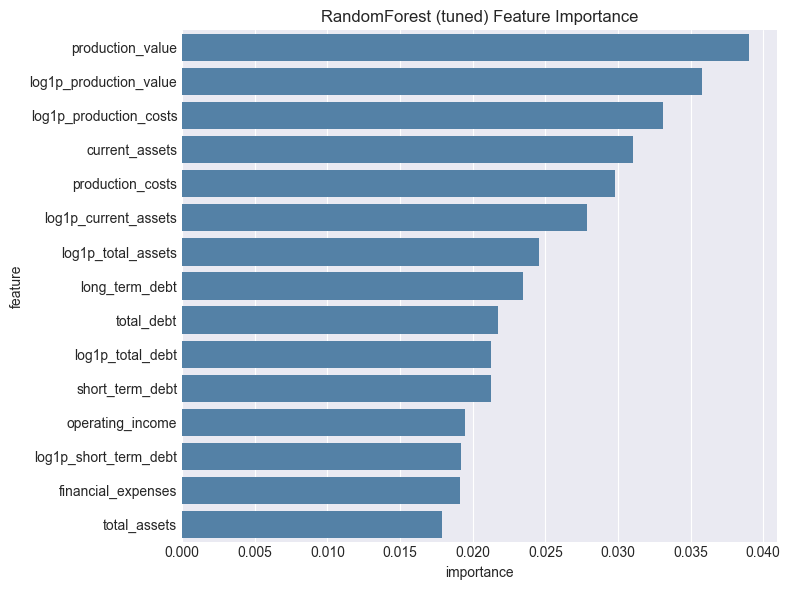

GradientBoosting (tuned) Feature Importance (top 15):
               feature  importance
log1p_production_costs    0.132294
log1p_production_value    0.129788
        legal_form_SPA    0.118058
      production_value    0.107582
  log1p_long_term_debt    0.053542
        current_assets    0.049077
      production_costs    0.037410
  log1p_current_assets    0.036454
      log1p_total_debt    0.031835
        legal_form_SRL    0.023345
        legal_form_SAS    0.020655
            total_debt    0.020586
          total_assets    0.016554
      operating_income    0.016310
        long_term_debt    0.015188


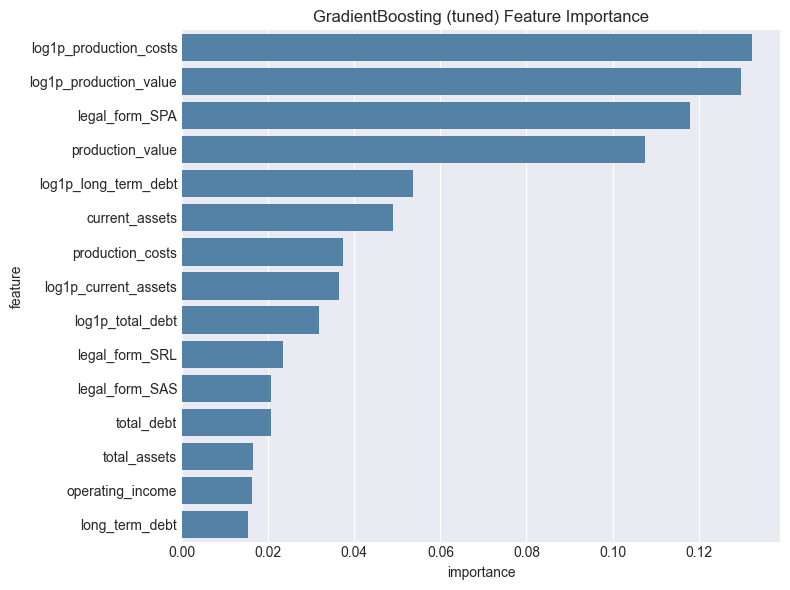

XGBoost (tuned) Feature Importance (top 15):
               feature  importance
      production_value    0.081104
      production_costs    0.060578
  log1p_current_assets    0.058145
        current_assets    0.026501
      log1p_total_debt    0.023364
log1p_production_costs    0.023193
        legal_form_SPA    0.022338
          total_assets    0.022152
log1p_production_value    0.020690
        long_term_debt    0.020344
        legal_form_SRL    0.018821
       short_term_debt    0.017006
            total_debt    0.015298
    log1p_total_assets    0.014236
        legal_form_SAS    0.013160


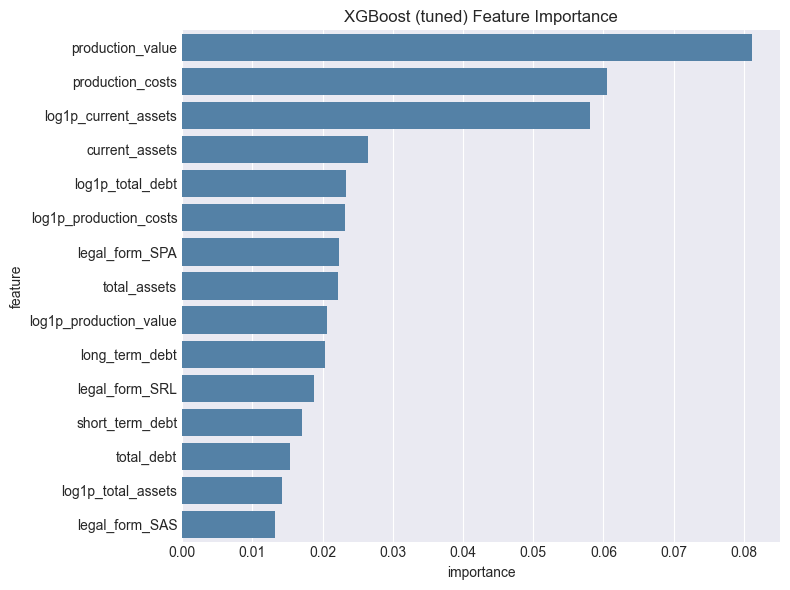

In [50]:
# Hyperparameter tuning (focused, leakage-safe) with target transform
# Tuning for RMSE + epsilon-MAPE (epsilon=0.02)
# NOTE: val/test have NaNs; use NaN-capable models only
# Tune only on TRAIN data using time-aware CV; evaluate on VAL after tuning.

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, GroupKFold
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

# Use scaled features if available
if 'X_train_scaled' in globals():
    X_tr = X_train_scaled
    X_va = X_val_scaled
else:
    X_tr = X_train
    X_va = X_val

# Ensure no NaNs for estimators that don't accept missing values
# Use train medians for numeric columns; fill remaining with 0 as a final safety net
if isinstance(X_tr, pd.DataFrame):
    train_median = X_tr.median(numeric_only=True)
    X_tr_no_nan = X_tr.copy()
    X_va_no_nan = X_va.copy()
    X_tr_no_nan = X_tr_no_nan.fillna(train_median)
    X_va_no_nan = X_va_no_nan.fillna(train_median)
    X_tr_no_nan = X_tr_no_nan.fillna(0)
    X_va_no_nan = X_va_no_nan.fillna(0)
else:
    # numpy arrays
    X_tr_no_nan = np.nan_to_num(X_tr, nan=0.0)
    X_va_no_nan = np.nan_to_num(X_va, nan=0.0)

# Winsorize target (train-only) to stabilize heavy tails
# Quantile transform features (train-only)
if isinstance(X_tr_no_nan, pd.DataFrame):
    qt = QuantileTransformer(n_quantiles=min(1000, len(X_tr_no_nan)), output_distribution='normal', random_state=RANDOM_STATE)
    X_tr_q = qt.fit_transform(X_tr_no_nan)
    X_va_q = qt.transform(X_va_no_nan)
else:
    qt = QuantileTransformer(n_quantiles=min(1000, X_tr_no_nan.shape[0]), output_distribution='normal', random_state=RANDOM_STATE)
    X_tr_q = qt.fit_transform(X_tr_no_nan)
    X_va_q = qt.transform(X_va_no_nan)

if 'winsorize_target' in globals():
    y_train_clip, y_val_clip, y_lo, y_hi = winsorize_target(y_train, y_val, lower=0.01, upper=0.99, hard_lo=REV_CHANGE_CAP_LO, hard_hi=REV_CHANGE_CAP_HI)
else:
    y_train_clip, y_val_clip = y_train.copy(), y_val.copy()
    y_lo, y_hi = None, None

# Transform target
yj = PowerTransformer(method="yeo-johnson", standardize=True)
Y_tr_t = yj.fit_transform(y_train_clip.to_numpy().reshape(-1,1)).ravel()
Y_va_t = yj.transform(y_val_clip.to_numpy().reshape(-1,1)).ravel()

# Tail-aware sample weights (train only)
sample_weights = 1.0 + np.log1p(np.abs(y_train_clip))


# Custom MAPE scorer (exclude zeros)
def mape_thresholded(y_true, y_pred, thr=NEAR_ZERO_THR):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = np.abs(y_true) >= thr
    if mask.sum() == 0:
        return np.nan, 0.0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    coverage = mask.mean() * 100
    return mape, coverage

def mape_safe(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape_scorer = make_scorer(mape_safe, greater_is_better=False)

def eps_mape(y_true, y_pred, eps=0.02):
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

mape_scorer = make_scorer(mape_safe, greater_is_better=False)

# Group-aware CV to prevent leakage across the same company
if 'company_id' in df_train.columns:
    groups = df_train['company_id']
    cv = GroupKFold(n_splits=3)
else:
    cv = TimeSeriesSplit(n_splits=3)


# Random Forest tuning
rf_param_dist = {
    'n_estimators': [200, 400, 600],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    rf_param_dist,
    n_iter=15,
    scoring=mape_scorer,
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_search.fit(X_tr_q, Y_tr_t, sample_weight=sample_weights, groups=groups if "groups" in locals() else None)
rf_best = rf_search.best_estimator_

# Optional: XGBoost tuning (if available)
try:
    from xgboost import XGBRegressor
    xgb_param_dist = {
        'n_estimators': [300, 600, 900],
        'learning_rate': [0.03, 0.05, 0.1],
        'max_depth': [3, 4, 5],
        'subsample': [0.7, 0.85, 1.0],
        'colsample_bytree': [0.7, 0.85, 1.0]
    }
    xgb_search = RandomizedSearchCV(
        XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1),
        xgb_param_dist,
        n_iter=12,
        scoring=mape_scorer,
        cv=cv,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    xgb_search.fit(X_tr_q, Y_tr_t, sample_weight=sample_weights, groups=groups if "groups" in locals() else None)
    xgb_best = xgb_search.best_estimator_
except Exception as e:
    xgb_best = None
    print(f"XGBoost tuning skipped: {e}")

# Gradient Boosting tuning
gb_param_dist = {
    'n_estimators': [200, 400, 600],
    'learning_rate': [0.03, 0.05, 0.1],
    'max_depth': [2, 3, 4],
    'subsample': [0.7, 0.85, 1.0]
}

gb_search = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=RANDOM_STATE),
    gb_param_dist,
    n_iter=12,
    scoring=mape_scorer,
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

gb_search.fit(X_tr_q, Y_tr_t, sample_weight=sample_weights, groups=groups if "groups" in locals() else None)
gb_best = gb_search.best_estimator_


# HistGradientBoosting tuning (robust + strong on skewed targets)
hgb_param_dist = {
    'max_depth': [3, 5, 7, None],
    'learning_rate': [0.03, 0.05, 0.1],
    'max_iter': [200, 400, 600],
    'min_samples_leaf': [10, 20, 50],
    'l2_regularization': [0.0, 0.1, 1.0],
    'max_bins': [64, 128, 255]
}

hgb_search = RandomizedSearchCV(
    HistGradientBoostingRegressor(random_state=RANDOM_STATE),
    hgb_param_dist,
    n_iter=12,
    scoring=mape_scorer,
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

hgb_search.fit(X_tr_q, Y_tr_t, sample_weight=sample_weights, groups=groups if 'groups' in locals() else None)
hgb_best = hgb_search.best_estimator_
# Metrics helper

def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return np.mean(np.where(denom == 0, 0, np.abs(y_true - y_pred) / denom)) * 100


def directional_accuracy(y_true, y_pred):
    return np.mean(np.sign(y_true) == np.sign(y_pred)) * 100




def eval_metrics(model, X, y_true, transformed=True, calibrate=False):
    preds_t = model.predict(X)
    preds = yj.inverse_transform(preds_t.reshape(-1,1)).ravel() if transformed else preds_t

    # optional linear calibration on predictions
    if calibrate:
        from sklearn.linear_model import LinearRegression
        lr = LinearRegression()
        lr.fit(preds.reshape(-1, 1), y_true)
        preds = lr.predict(preds.reshape(-1, 1))

    rmse = mean_squared_error(y_true, preds, squared=False)
    mae = mean_absolute_error(y_true, preds)
    mdae = median_absolute_error(y_true, preds)
    mape = mape_safe(y_true, preds)
    mape_thr, mape_cov = mape_thresholded(y_true, preds, thr=NEAR_ZERO_THR)
    r2 = r2_score(y_true, preds)

    # tail metrics
    tail_mask = y_true.abs() > 50
    if tail_mask.any():
        tail_rmse = mean_squared_error(y_true[tail_mask], preds[tail_mask], squared=False)
        tail_mae = mean_absolute_error(y_true[tail_mask], preds[tail_mask])
    else:
        tail_rmse, tail_mae = np.nan, np.nan

    return rmse, mae, mdae, mape, mape_thr, mape_cov, r2, smape(y_true, preds), directional_accuracy(y_true, preds), tail_rmse, tail_mae





results = []

if 'hgb_best' in locals():
    rmse, mae, mdae, mape, mape_thr, mape_cov, r2, sm, da, trmse, tmae = eval_metrics(hgb_best, X_va_q, y_val_clip, transformed=True)
    results.append({'Model': 'HistGradientBoosting (tuned)', 'RMSE': rmse, 'MAE': mae, 'MdAE': mdae, 'MAPE': mape, 'MAPE_thr': mape_thr, 'MAPE_cov(%)': mape_cov, 'SMAPE': sm, 'R2': r2, 'DirectionalAcc(%)': da, 'Tail_RMSE': trmse, 'Tail_MAE': tmae})

rmse, mae, mdae, mape, mape_thr, mape_cov, r2, sm, da, trmse, tmae = eval_metrics(rf_best, X_va_q, y_val_clip, transformed=True)
results.append({'Model': 'RandomForest (tuned)', 'RMSE': rmse, 'MAE': mae, 'MdAE': mdae, 'MAPE': mape, 'MAPE_thr': mape_thr, 'MAPE_cov(%)': mape_cov, 'SMAPE': sm, 'R2': r2, 'DirectionalAcc(%)': da, 'Tail_RMSE': trmse, 'Tail_MAE': tmae})

rmse, mae, mdae, mape, mape_thr, mape_cov, r2, sm, da, trmse, tmae = eval_metrics(gb_best, X_va_q, y_val_clip, transformed=True)
results.append({'Model': 'GradientBoosting (tuned)', 'RMSE': rmse, 'MAE': mae, 'MdAE': mdae, 'MAPE': mape, 'MAPE_thr': mape_thr, 'MAPE_cov(%)': mape_cov, 'SMAPE': sm, 'R2': r2, 'DirectionalAcc(%)': da, 'Tail_RMSE': trmse, 'Tail_MAE': tmae})

if xgb_best is not None:
    rmse, mae, mdae, mape, mape_thr, mape_cov, r2, sm, da, trmse, tmae = eval_metrics(xgb_best, X_va_q, y_val_clip, transformed=True)
    results.append({'Model': 'XGBoost (tuned)', 'RMSE': rmse, 'MAE': mae, 'MdAE': mdae, 'MAPE': mape, 'MAPE_thr': mape_thr, 'MAPE_cov(%)': mape_cov, 'SMAPE': sm, 'R2': r2, 'DirectionalAcc(%)': da, 'Tail_RMSE': trmse, 'Tail_MAE': tmae})

results_df = pd.DataFrame(results).sort_values('RMSE')
print("Tuned models evaluated on validation set (original scale, tail metrics included):")
display(results_df)

print("Hyperparameter tuning complete!")






# Feature importance (tuned models)
try:
    if isinstance(X_tr, pd.DataFrame):
        feature_names = X_tr.columns.tolist()
    else:
        feature_names = X_train.columns.tolist() if 'X_train' in globals() else [f'f{i}' for i in range(X_tr.shape[1])]

    def print_and_plot_importance(model, title, top_n=15):
        if not hasattr(model, 'feature_importances_'):
            print(f"{title}: no feature_importances_ attribute")
            return
        importances = model.feature_importances_
        fi = pd.DataFrame({'feature': feature_names, 'importance': importances})
        fi = fi.sort_values('importance', ascending=False).head(top_n)
        print(f"{title} (top {top_n}):")
        print(fi.to_string(index=False))

        plt.figure(figsize=(8, 6))
        sns.barplot(data=fi, x='importance', y='feature', color='steelblue')
        plt.title(title)
        plt.tight_layout()
        plt.show()

    print_and_plot_importance(rf_best, 'RandomForest (tuned) Feature Importance')
    print_and_plot_importance(gb_best, 'GradientBoosting (tuned) Feature Importance')
    if xgb_best is not None:
        print_and_plot_importance(xgb_best, 'XGBoost (tuned) Feature Importance')
except Exception as e:
    print(f"Feature importance skipped: {e}")


## 6. Model Evaluation

Compare models and select the best one.

In [51]:
# TODO: Create model comparison table
# Compare all models on validation set using appropriate metrics

# For Challenge 1: F1-Score, AUC-ROC, Precision, Recall
# For Challenge 2: Weighted F1, Macro F1, Accuracy, Confusion Matrix
# For Challenge 3: RMSE, MAE, MAPE, R², Directional Accuracy

# Example comparison:
# models_comparison = pd.DataFrame({
#     'Model': ['Baseline', 'Random Forest', 'XGBoost'],
#     'F1-Score': [...],
#     'AUC-ROC': [...],
#     'Precision': [...],
#     'Recall': [...]
# })
# print(models_comparison)

In [52]:
# TODO: Confusion Matrix (for classification)
# from sklearn.metrics import ConfusionMatrixDisplay

# ConfusionMatrixDisplay.from_estimator(best_model, X_val_scaled, y_val)
# plt.title('Confusion Matrix - Best Model')
# plt.show()

In [53]:
# TODO: ROC Curve (for binary classification)
# from sklearn.metrics import RocCurveDisplay

# RocCurveDisplay.from_estimator(best_model, X_val_scaled, y_val)
# plt.title('ROC Curve - Best Model')
# plt.show()

**Model Selection:**

TODO: Justify your final model choice
- 
- 

## 7. Interpretation and Business Insights

Explain the model and extract business value.

In [54]:
# TODO: Feature Importance
# For tree-based models, use built-in feature importance
# For other models, consider SHAP values

# Example:
# feature_importance = pd.DataFrame({
#     'feature': feature_cols,
#     'importance': best_model.feature_importances_
# }).sort_values('importance', ascending=False)

# plt.figure(figsize=(10, 6))
# plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
# plt.xlabel('Importance')
# plt.title('Top 15 Most Important Features')
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.show()

In [55]:
# TODO: Error Analysis
# - Which cases does the model misclassify/mispredicts?
# - Are there patterns in the errors?
# - How do errors vary by sector, size, region, etc.?

# Example:
# errors_df = df_val.copy()
# errors_df['prediction'] = y_pred
# errors_df['error'] = (errors_df['prediction'] != errors_df[target_col])

# print("Error rate by sector:")
# print(errors_df.groupby('ateco_sector')['error'].mean().sort_values(ascending=False))

**Business Insights:**

TODO: Translate technical findings into business language

**Key Risk Factors** (for bankruptcy/health challenges):
1. 
2. 
3. 

**Revenue Drivers** (for forecasting challenge):
1. 
2. 
3. 

**Actionable Recommendations:**
- 
- 
- 

## 8. Conclusions and Future Work

Summarize findings and discuss limitations.

**Summary:**

TODO: Summarize your work
- 
- 

**Performance vs Targets:**

TODO: Compare your results to challenge targets
- My F1-Score: [X.XX] vs Target: [0.55-0.70]
- ...

**Model Limitations:**

TODO: Discuss limitations honestly
1. 
2. 
3. 

**Future Improvements:**

TODO: What would you do with more time?
1. 
2. 
3. 

**Lessons Learned:**

TODO: Reflect on the experience
- 
- 

---

## Final Checklist

Before submitting, verify:

- [ ] All code cells execute without errors
- [ ] Markdown cells explain each step clearly
- [ ] Visualizations are clear and labeled
- [ ] Feature importance is analyzed
- [ ] Error analysis is performed
- [ ] Business insights are provided
- [ ] Model limitations are discussed
- [ ] Code is well-commented
- [ ] Results meet or exceed minimum performance targets
- [ ] No data leakage (temporal split, proper scaling, etc.)
- [ ] Citations for any external code/resources

**Good luck with your challenge!** 🚀